<a href="https://colab.research.google.com/github/Cole-Pd/DeepDive/blob/main/Project_4_Submit_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title

## Problem Definition


When producing a new song to Spotify an artist may find predicting their popularity to be valuable. To address this challange we are proposing a supervised model. More specifically we will explore and implement Random Forest Regression across songs that have reached the top 200. For the purpose of our analysis our target will be 'Streams' and we will measure the sucsess of our model using root mean square error. We will crossvalidate our results and report their mean value.

## Data Collection/Sources


Our data set has around 1500 songs. Some of the features in this dataset may make good targets but do not help us in predicting what features actually contribute to 'Streams'. They will be dropped or experiemented with for target selection.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns
from datetime import datetime, timedelta

In [19]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
#!curl -s -I {url}

In [ ]:
df = pd.read_csv(url)
pd.options.display.max_columns = 50
df.T

## Data Cleaning


Many of our continuous variables ex: "Loudness", "Streams", and "Danceability" are strings. They apear to not have null values. However when we try to change their data types, begin encountering upfitting incompatibilites to their numeric counterparts. This looks like rows containing empty strings, date times with missing month and or days, and some values seperated by commas.

In [21]:
df.info() # Some of our numeric columns are objects.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [22]:
#Here we remove the comma preventing streams from becoming a Float.
df['Streams'] = df['Streams'].apply(lambda x: x.replace(",",""))

In [23]:
as_type_float = [
                 'Streams',
                 'Artist Followers',
                 'Popularity',
                 'Danceability',
                 'Energy',
                 'Loudness',
                 'Speechiness',
                 'Acousticness',
                 'Liveness',
                 'Tempo',
                 'Duration (ms)',
                 'Valence'
                 ]

In [24]:
#Some of the numeric columns are upfitted to a string.
#This loop attempts to change their data type to a float.

these_ones_dont_work = []

for element in as_type_float:
  try:
    df[element] = df[element].astype('float')
  except:
    these_ones_dont_work.append(element)

these_ones_dont_work

['Artist Followers',
 'Popularity',
 'Danceability',
 'Energy',
 'Loudness',
 'Speechiness',
 'Acousticness',
 'Liveness',
 'Tempo',
 'Duration (ms)',
 'Valence']

In [25]:
# These rows contain an empty string for every column contained in the list "These rows dont work."
for element in these_ones_dont_work:
  print(df[df[element] == ' '].index)

Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')
Int64Index([35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], dtype='int64')


In [26]:
df = df.drop(index =[35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538], axis = 0 )

In [27]:
#These rows contain duplicated Song ID's
df = df.drop_duplicates('Song ID', 'first')
df = df.drop(['Song ID','Index','Song Name'], axis = 1)
df.reset_index(inplace=True)

<ipython-input-27-23c48356d4b9>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop_duplicates except for the argument 'subset' will be keyword-only.
  df = df.drop_duplicates('Song ID', 'first')


In [28]:
#Here we are confirming there are no more empty strings.
for element in these_ones_dont_work:
  print(df[df[element] == ' '].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [29]:
# This confirms all of the columns we have chosen to change to floats
# have infact been changed to floats.
these_ones_still_dont_work = []


for element in as_type_float:
  try:
    df[element] = df[element].astype('float')
  except:
    these_ones_still_dont_work.append(element)

these_ones_still_dont_work

[]

In [30]:
#We used trial and error to find all of the rows where our datetime
#format had missing elements. See below where we do not have Month or day.
filter = df['Release Date'] == '2016'
df[filter]

,index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Streams,Artist,Artist Followers,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
1216,1250,117,8,2020-02-14--2020-02-21,4176083.0,Lizzo,3991674.0,"['dance pop', 'escape room', 'minnesota hip ho...",2016,2020-04-10--2020-04-17\n2020-04-03--2020-04-10...,71.0,0.668,0.892,-3.001,0.0645,0.298,0.735,95.927,159011.0,0.478,F


In [31]:
#This is the list of dates with missing date time information.
df = df.drop(index = [154, 230, 501, 614, 630, 619,
                      650, 651, 656, 1032, 662, 663,
                      673, 857,  1216,
                      ], axis = 0)

In [32]:
# Here we use a lambda function to apply datatime element wise to the Release Date series.
df['Release Date'] = df['Release Date'].apply(lambda x : datetime.strptime(x,'%Y-%m-%d').day) ;

In [35]:
#Here we deconstruct the list of each element in Genre using regex
#We then encode unique elements and join them to the DataFrame.
df = df.join(df['Genre'].str.replace('[','',regex = True).str.replace(']', '', regex = True).str.get_dummies(', '))

In [33]:
#These are the variables we will use for our anaysis.
#They have been cleaned.
chosen = [
        'Streams',
        'Release Date',
        'Danceability',
        'Energy',
        'Loudness',
        'Speechiness',
        'Acousticness',
        'Liveness',
        'Tempo',
        'Duration (ms)',
        'Valence'
       ]


In [34]:
# After encoding genre we will drop these columns from the DF,
# instead of selecting every column from the df.
to_drop = [
        'Highest Charting Position',
        'Number of Times Charted',
        'Week of Highest Charting',
        'Artist',
        'Artist Followers',
        'Genre',
        'Popularity',
        'Chord',
        'Weeks Charted',
        'Streams'
       ]

## Exploratory Data Analysis


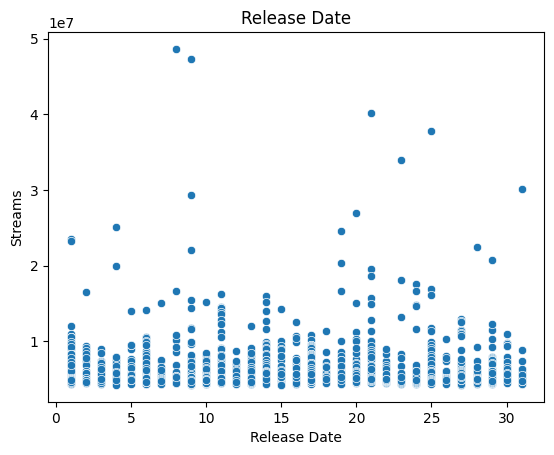

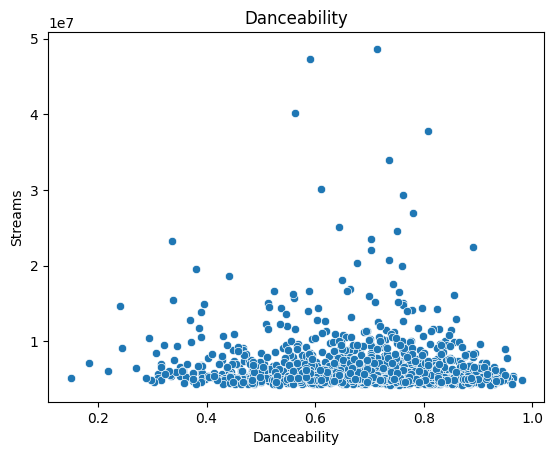

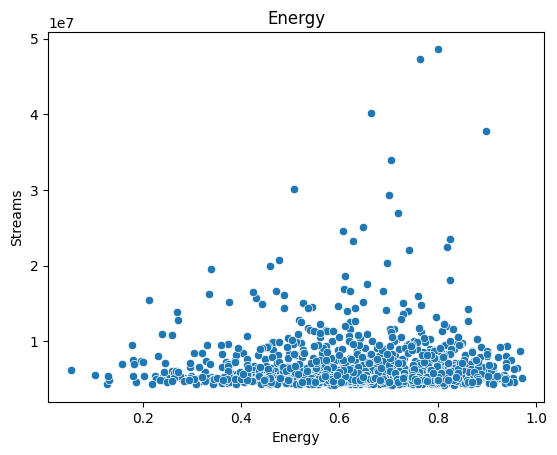

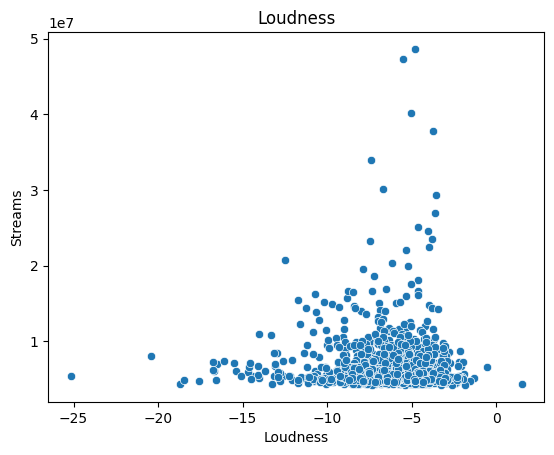

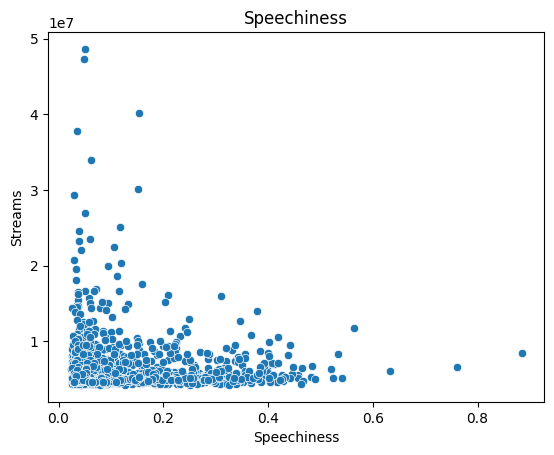

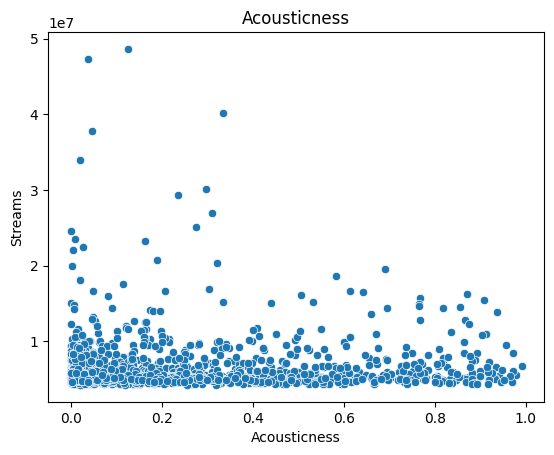

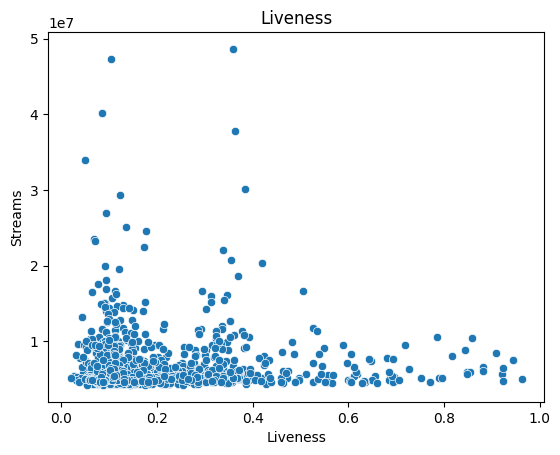

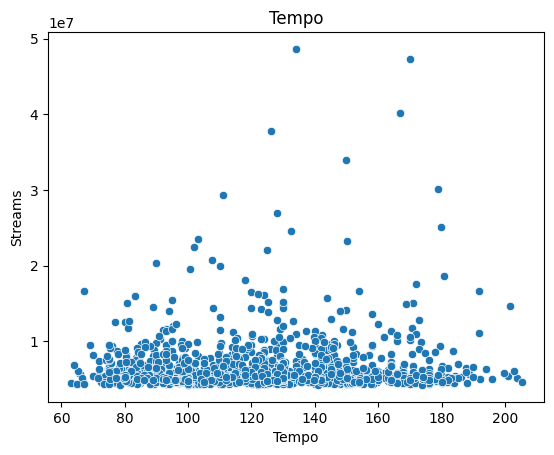

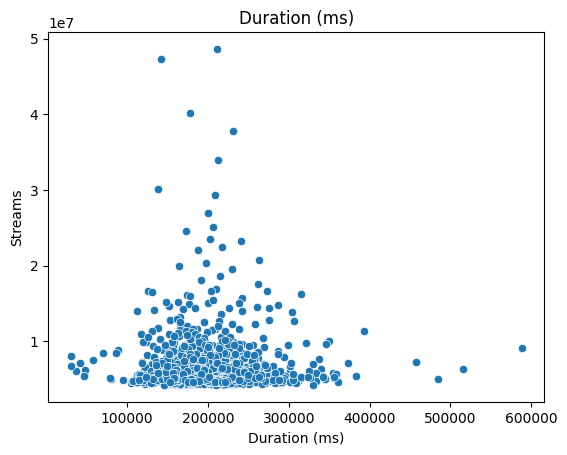

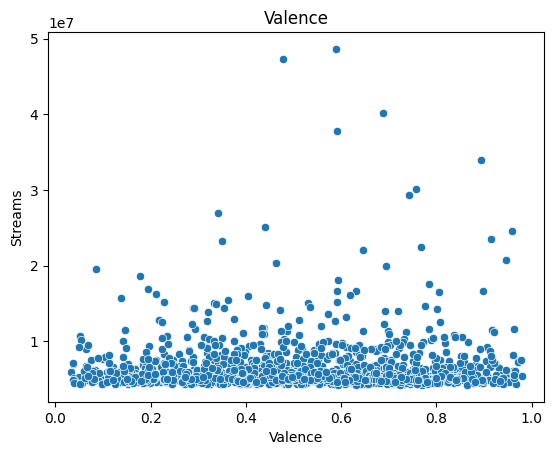

In [36]:
for feature in chosen:
  if feature != 'Streams':
      sns.scatterplot(x = df[feature], y = df['Streams']) ;
      plt.title(feature);
      plt.show();

## Processing


In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [38]:
#Here our model uses continuous features with out encoded genres.
X = df[chosen].drop('Streams', axis = 1)
y = df['Streams']

In [39]:
numLoops = 100

mean_error = np.zeros(numLoops)


for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = RandomForestRegressor(max_depth=10, n_estimators = 100, criterion = 'poisson')
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error[idx] = mean_squared_error(y_test, y_pred)

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
print(f'The Max Streams is {y.max()}')
print(f'The Min Streams is {y.min()}')
print(f'The Mean Streams is {y.mean()}')

RMSE: 3378989.028874251
RMSE_std: 526363.8190560983
The Max Streams is 48633449.0
The Min Streams is 4214147.0
The Mean Streams is 6322411.081279147


In [40]:
param_grid = {
    'n_estimators': [25, 50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [ 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]
}

In [41]:
#This often does not produce the same results.
# And it take a loooooong time to run
# model = RandomForestRegressor()
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
# grid_search = GridSearchCV(estimator =  model,
#                              param_grid = param_grid,
#                              cv=5, scoring ='neg_mean_squared_error',
#                              verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [42]:
numLoops = 100

mean_error = np.zeros(numLoops)


for i in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = RandomForestRegressor(max_depth = 10,
  min_samples_leaf = 4,
  min_samples_split = 5,
  n_estimators = 200,
  criterion = 'poisson')
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error[i] = mean_squared_error(y_test, y_pred)

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
print(f'The Max Streams is {y.max()}')
print(f'The Min Streams is {y.min()}')
print(f'The Mean Streams is {y.mean()}')

RMSE: 3297426.0136719025
RMSE_std: 659443.038698699
The Max Streams is 48633449.0
The Min Streams is 4214147.0
The Mean Streams is 6322411.081279147


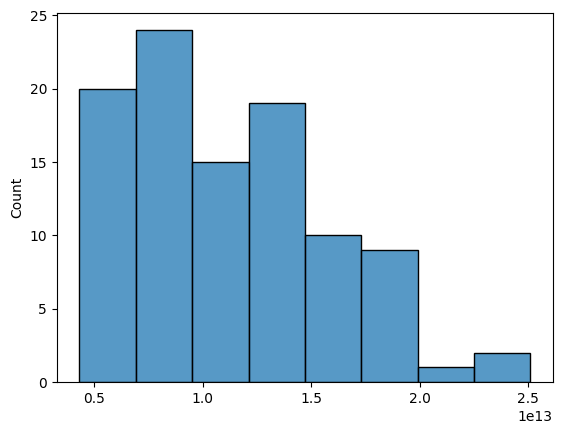

In [43]:
sns.histplot(mean_error) ;

In [ ]:
#Here find feature importances and sort them acording to their model weights.
features = model.feature_importances_
features.sort()
selections = zip(features, X.columns)
l = list(selections)
l

In [45]:
#From that dataset we have chosen the features with the top ~75% of importance.
important_features = ['Valence', 'Duration (ms)', 'Tempo', 'Liveness', 'Acousticness', 'Speechiness']
X_if = df[important_features]

In [ ]:
numLoops = 100

mean_error_if = np.zeros(numLoops)
mpe = []

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X_if,y,test_size=0.2)
  model = RandomForestRegressor(
  criterion = 'poisson',
  max_depth = 20,
  min_samples_leaf = 4,
  min_samples_split = 5,
  n_estimators = 200)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error_if[idx] = mean_squared_error(y_test, y_pred)
  mpe.append((np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100)

print(f'RMSE: {np.sqrt(mean_error_if).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error_if).std()}')
print(f'The Max Streams is {y.max()}')
print(f'The Min Streams is {y.min()}')
print(f'The Mean Streams is {y.mean()}')
print(f'The Streans Mean RSMPE is {round((sum(mpe) / numLoops),2)}')

In [47]:
#Here our model uses both contious features and encoded Genres.
X = df.drop(to_drop, axis = 1)
y = df['Streams']

In [48]:
# This often does not produce the same results.
# For the purpose of saving time we will not find new Hyper Parameters.
# model = RandomForestRegressor()
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
# grid_search = GridSearchCV(estimator =  model,
#                              param_grid = param_grid,
#                              cv=5, scoring ='neg_mean_squared_error',
#                              verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [49]:
numLoops = 100

mean_error = np.zeros(numLoops)


for i in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = RandomForestRegressor(max_depth = 10,
  min_samples_leaf = 4,
  min_samples_split = 5,
  n_estimators = 200,
  criterion = 'poisson')
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error[i] = mean_squared_error(y_test, y_pred)

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
print(f'The Max Streams is {y.max()}')
print(f'The Min Streams is {y.min()}')
print(f'The Mean Streams is {y.mean()}')

RMSE: 1536054.945697177
RMSE_std: 300065.0532138699
The Max Streams is 48633449.0
The Min Streams is 4214147.0
The Mean Streams is 6322411.081279147


In [ ]:
features = model.feature_importances_
features.sort()
selections = zip(features, X.columns)
l = list(selections)
l

In [58]:
#This can change around ocasionally... Based on what our forest happened to pick
important_features = [
"'sertanejo universitario'",
"'sertanejo'",
"'sheffield indie'",
"'shiver pop'",
"'show tunes'",
"'singer-songwriter'",
"'slap house'",
"'soft rock'",
"'soul'",
"'south african house'",
"'southern hip hop'",
"'southern soul'",
"'sudanese pop'",
"'surf punk'"
]

In [63]:
#We again select high feature importances. and retrain our model.
X_if = df[important_features]

In [60]:
numLoops = 100

mean_error_if = np.zeros(numLoops)
mpe = []
                                               #We are using the features
for idx in range(0,numLoops):                  #we identified as 'Important'
  X_train, X_test, y_train, y_test = train_test_split(X_if,y,test_size=0.2)
  model = RandomForestRegressor(
  criterion = 'poisson',
  max_depth = 20,
  min_samples_leaf = 4,
  min_samples_split = 5,
  n_estimators = 200)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error_if[idx] = mean_squared_error(y_test, y_pred)
  mpe.append((np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100)

print(f'RMSE: {np.sqrt(mean_error_if).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error_if).std()}')
print(f'The Max Streams is {y.max()}')
print(f'The Min Streams is {y.min()}')
print(f'The Mean Streams is {y.mean()}')
print(f'The Streans Mean RSMPE is {round((sum(mpe) / numLoops),2)}')


RMSE: 3359951.9025173592
RMSE_std: 654682.9328023109
The Max Streams is 48633449.0
The Min Streams is 4214147.0
The Mean Streams is 6322411.081279147
The Streans Mean RSMPE is 28.58


## Data Visualization/Communication of Results


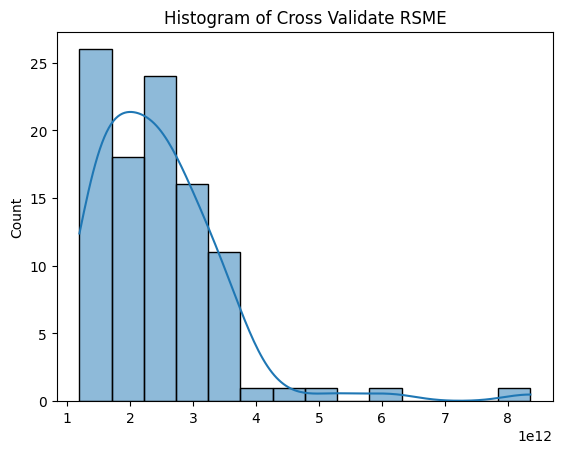

In [74]:
sns.histplot(mean_error, kde = True) ;
plt.title('Histogram of Cross Validate RSME') ;
plt.show()

Our best results were obtained when running the model with an encoded genre!